# Flight prices prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
import os

In [2]:
os.listdir()

['flight prices.ipynb', 'flights.csv']

In [3]:
df = pd.read_csv("./flights.csv")

## Sort and clean data

### Check for NaN

In [4]:
df.isna().sum()

Airline           0
Source            0
Destination       0
Total_Stops       0
Price             0
Date              0
Month             0
Year              0
Dep_hours         0
Dep_min           0
Arrival_hours     0
Arrival_min       0
Duration_hours    0
Duration_min      0
dtype: int64

### Remove outliers

In [5]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numerical_columns = ['Price', 'Dep_hours', 'Dep_min', 'Arrival_hours', 'Arrival_min', 'Duration_hours', 'Duration_min']
for column in numerical_columns:
    df = remove_outliers_iqr(df, column)


### Create route feature of source and destination

In [6]:
df["Route"] = df["Source"]+"-" + df["Destination"]

In [7]:
df = df.drop(["Source","Destination"],axis=1)

### Emerge duration hours and min 

In [8]:
df["Duration(min)"] = df["Duration_hours"] * 60 + df["Duration_min"]
df.drop(["Duration_hours", "Duration_min"], axis = 1, inplace = True)

### Remove years column
**it is always 2019**

In [9]:
df.drop(columns = ['Year'], inplace = True)

**Convert time of arrival and departure to category**

In [10]:
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 22:
        return 'evening'
    else:
        return 'night'

df['Dep_time'] = df['Dep_hours'].apply(time_of_day)
df['Arrival_time'] = df['Arrival_hours'].apply(time_of_day)

df.drop(["Dep_hours", "Dep_min","Arrival_hours", "Arrival_min"], axis = 1, inplace = True)

### Check for duplicates

In [11]:
df.duplicated().sum()

379

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.duplicated().sum()

0

In [14]:
len(df)

10138

In [15]:
df.head()

,Airline,Total_Stops,Price,Date,Month,Route,Duration(min),Dep_time,Arrival_time
0,IndiGo,0,3897,24,3,Banglore-New Delhi,170,night,night
1,Air India,2,7662,1,5,Kolkata-Banglore,445,morning,afternoon
2,Jet Airways,2,13882,9,6,Delhi-Cochin,1140,morning,night
3,IndiGo,1,6218,12,5,Kolkata-Banglore,325,evening,night
4,IndiGo,1,13302,1,3,Banglore-New Delhi,285,afternoon,evening


# Get valuable data from tables 

## set plots colors

In [16]:
cmap = plt.get_cmap("tab20")
colors = []
for step in np.linspace(0,1,12):
    colors.append(clr.rgb2hex(cmap(step)))

## plot some graphs

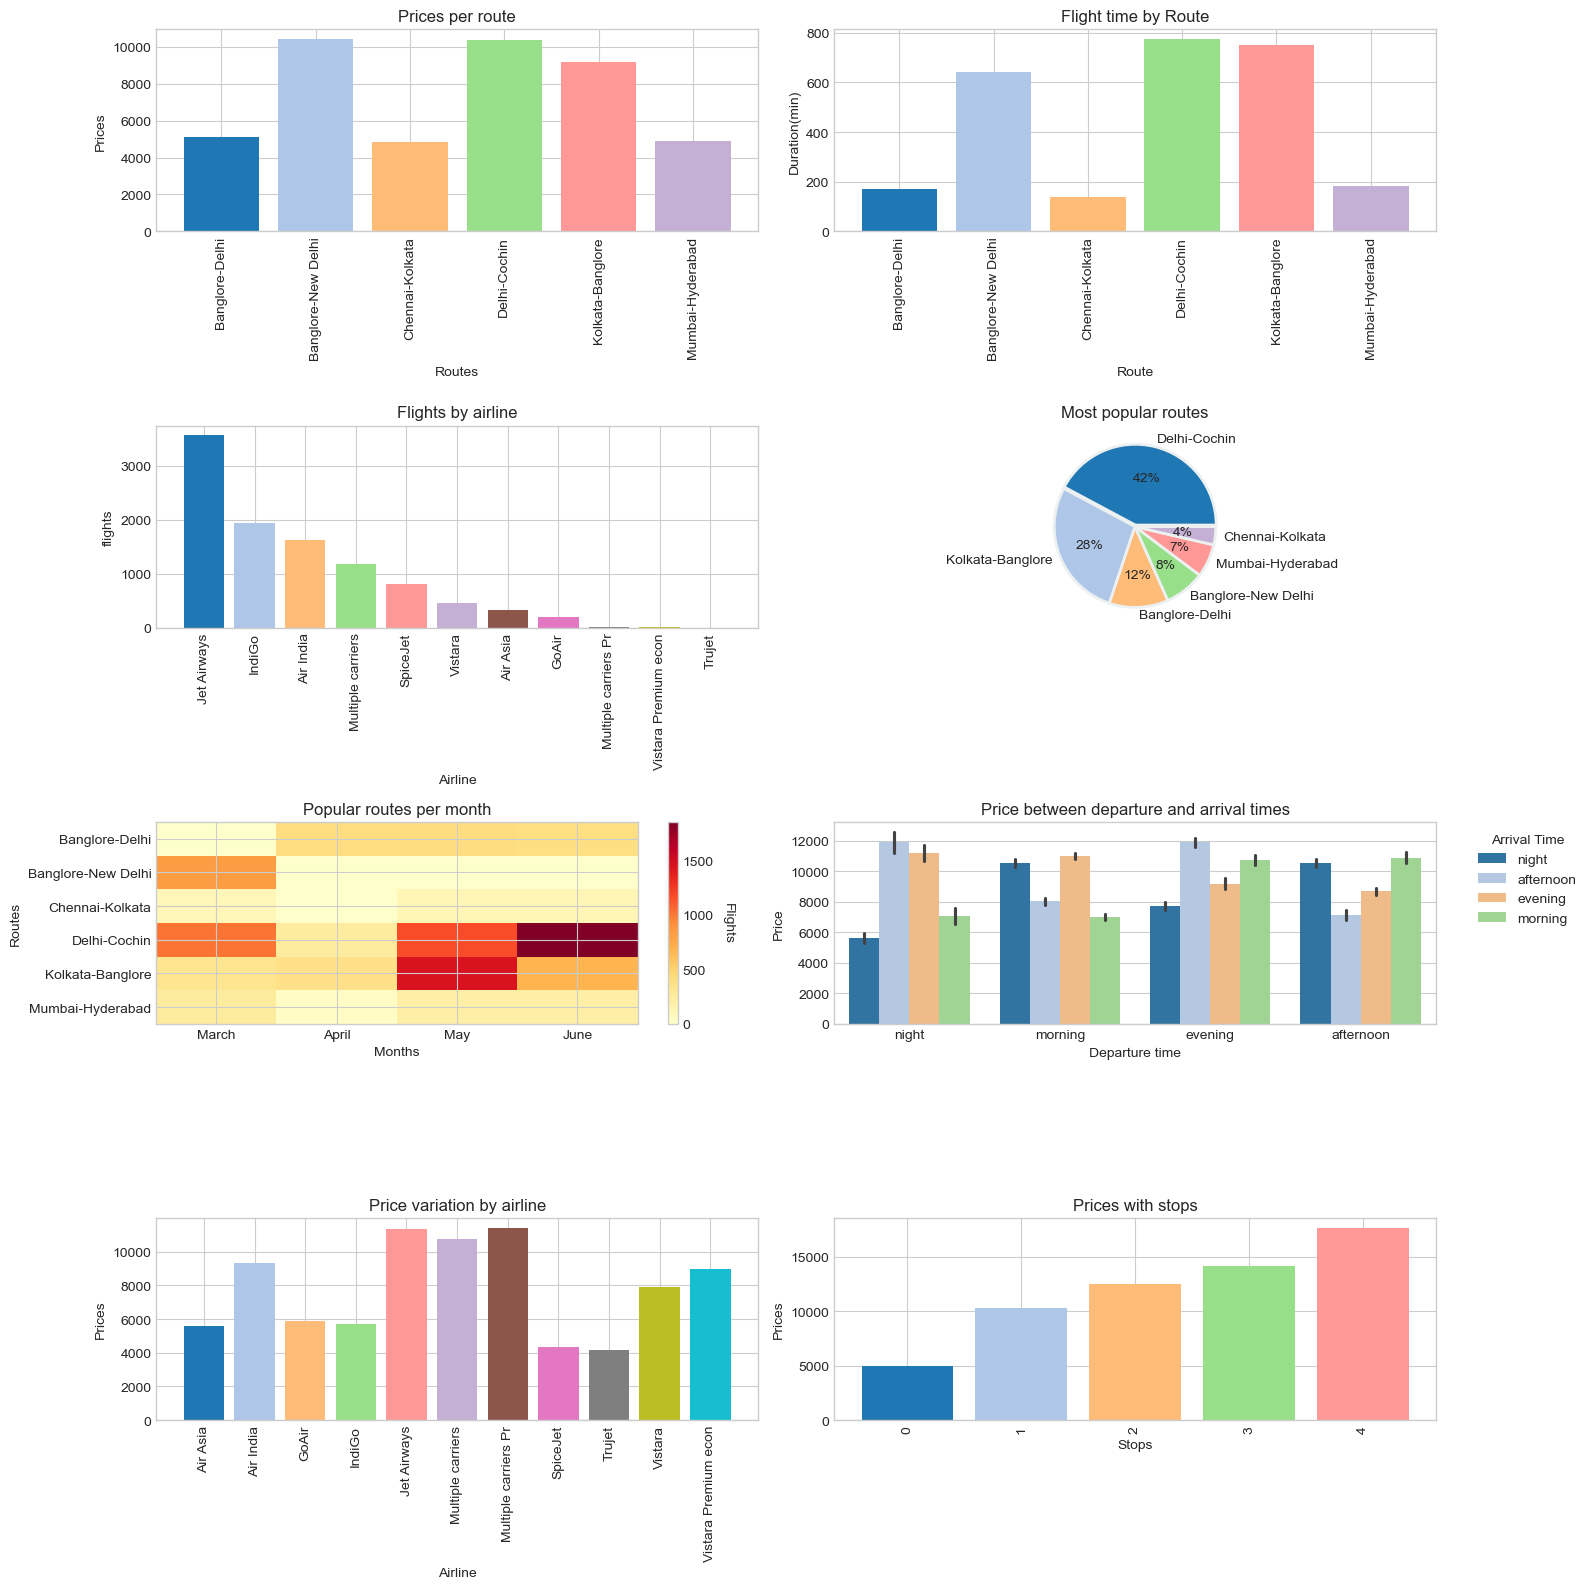

In [17]:
# Prices per airline
with plt.style.context("seaborn-v0_8-whitegrid"):
    airline_price = df.groupby("Airline")["Price"].mean().astype(int)

    airline_ticks = [key[:20] for key in airline_price.keys()]

    fig,(
        (ax1,ax2),
        (ax3,ax4),
        (ax5,ax6),
        (ax7,ax8)
        )=plt.subplots(
        figsize = (16,16),
        nrows = 4,
        ncols = 2
    )

    # prices by routes
    price_route = df.groupby('Route')['Price'].mean()
    ax1.bar(
        price_route.keys(),
        price_route,
        color = colors
    )
    ax1.set_xticks(ticks = price_route.keys(),labels = price_route.keys(),rotation=90)
    ax1.set(
            title = "Prices per route",
            xlabel = "Routes",
            ylabel = "Prices"
        )
    # fligt durations per airline
    route_duration = df.groupby("Route")["Duration(min)"].mean().astype(int)
    ax2.bar(route_duration.keys(), 
            route_duration,
            color = colors
        )
    
    ax2.set(
        title = "Flight time by Route",
        xlabel = "Route",
        ylabel = "Duration(min)"
    )

    ax2.set_xticks(ticks= route_duration.keys(),labels = route_duration.keys(),rotation=90)

    #flights per airline
    flight_count = df["Airline"].value_counts()

    ax3.bar(flight_count.index,
            flight_count.values,
            color = colors
        )
    ax3.set(
        title = "Flights by airline",
        xlabel = "Airline",
        ylabel = "flights"
    )
    ax3.set_xticks(ticks = airline_price.keys(),labels = airline_ticks,rotation=90)

    # popular routes
    routes_count = df['Route'].value_counts()

    ax4.pie(
        routes_count.values,
        labels=routes_count.index,
        explode=[0.02,0,0,0,0,0],
        colors = colors,
        wedgeprops = {
            'edgecolor': '#ecf0f1',
            'linewidth':2
        },
        autopct='%1.0f%%',
        
    )
    ax4.set(
        title = "Most popular routes"
    )

    # Popular routes by month
    route_month_counts = df.groupby(['Route','Month']).size().reset_index(name='Flights').sort_values(by='Month')
    pivot_table = route_month_counts.pivot(index='Route', columns='Month', values='Flights').fillna(0)
    months = pd.to_datetime(route_month_counts['Month'],format="%m").dt.month_name()
    pivot_table = pivot_table.sort_index()
    cax = ax5.imshow(pivot_table, cmap='YlOrRd', aspect='auto')
    ax5.set_xticks(ticks=range(len(pivot_table.columns)), labels=months.unique())
    ax5.set_yticks(ticks=range(len(pivot_table.index)), labels=pivot_table.index)
    ax5.set(
        title = "Popular routes per month",
        xlabel = "Months",
        ylabel = "Routes"
    )
    cbar = fig.colorbar(cax, ax=ax5, orientation='vertical')
    cbar.set_label('Flights', rotation=270, labelpad=15)
  
    # Price between departure and arrival times
    sns.barplot(x='Dep_time', y='Price', hue='Arrival_time', data=df, palette=colors[:4],ax=ax6)
    ax6.set(
        title = "Price between departure and arrival times",
        xlabel = "Departure time",
        ylabel = "Price"
    )
    ax6.legend(title='Arrival Time', bbox_to_anchor=(1.05, 1), loc='upper left')

 
    ax7.bar(airline_price.keys(), 
                airline_price,
                color= colors)
    ax7.set(
        title = "Price variation by airline",
        xlabel = "Airline",
        ylabel = "Prices"
    )
    ax7.set_xticks(ticks = airline_price.keys(),labels=airline_ticks ,rotation=90)

    # Prices to stops
    price_stops = df.groupby('Total_Stops')['Price'].mean()
    ax8.bar(
        price_stops.keys(),
        price_stops,
        color = colors
    )
    ax8.set_xticks(ticks = price_stops.keys(),labels = price_stops.keys(),rotation=90)
    ax8.set(
            title = "Prices with stops",
            xlabel = "Stops",
            ylabel = "Prices"
        )
    fig.tight_layout();
    plt.show();

# Predicting flight prices

### preparing models

In [18]:
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

regression_models = {"Ridge": Ridge(),
                     "SVR_linear": SVR(),
                     "SVR_rbf": SVR(kernel="rbf"),
                     "RandomForestRegressor": RandomForestRegressor()}

# Create an empty dictionary for the regression results
regression_results = {}

categorical_features = ["Airline", "Total_Stops", 'Date', 'Month', 'Route', 'Dep_time', 'Arrival_time']
numeric_features = ['Duration(min)']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Loop through the items in the regression_models dictionary
for model_name, model in regression_models.items():
    
    # Create a model Pipeline with a preprocessor step and model step
    model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("model", model)])
    
    # Fit the model Pipeline to the car sales training data
    print(f"Fitting {model_name}...")
    model_pipeline.fit(X_train, y_train)
    
    # Score the model Pipeline on the test data appending the model_name to the 
    # results dictionary
    print(f"Scoring {model_name}...")
    regression_results[model_name] = model_pipeline.score(X_test, y_test)

regression_results

Fitting Ridge...
Scoring Ridge...
Fitting SVR_linear...
Scoring SVR_linear...
Fitting SVR_rbf...
Scoring SVR_rbf...
Fitting RandomForestRegressor...


KeyboardInterrupt: 

### Model tuning

**Using GridSerachCV**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definiera hyperparameter grid för RandomForestRegressor
param_grid = {
    'model__n_estimators': [100, 200,300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2,5],
    'model__min_samples_leaf': [2,4],
    'model__max_features': ['sqrt']
}
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                                     ("model", RandomForestRegressor())])
# Skapa en GridSearchCV objekt
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5,
                           verbose=1,
                           n_jobs=1) 

# Anpassa GridSearchCV till träningsdata
print("Fitting GridSearchCV...")
grid_search.fit(X_train, y_train)

# Hämta bästa parametrar och bästa score
best_params = grid_search.best_params_


Fitting GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}


In [ ]:
best_params

{'model__max_depth': 20,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 5,
 'model__n_estimators': 200}

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Model setup
model = RandomForestRegressor(
        max_depth=20,
        max_features='sqrt',
        min_samples_leaf=2,
        min_samples_split=5,
        n_estimators=200
)

X = df.drop('Price',axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    pd.get_dummies(X)
    , y, test_size=0.2, random_state=42)

model.fit(X_train,y_train)
y_preds = model.predict(X_test)

print('Regression metrics on the test set')
print(f'r2: {r2_score(y_test,y_preds)*100:.2f}%')
print(f'mean_absolute_error: {mean_absolute_error(y_test,y_preds)}')
print(f'mean_squared_error: {mean_squared_error(y_test,y_preds)}')

Regression metrics on the test set
r2: 82.10%
mean_absolute_error: 1229.1407307097613%
mean_squared_error: 2933265.159841384%


In [ ]:
model.score(X_test,y_test)

0.8210073678651076